In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import sklearn.metrics as metrics

## Read bidding log for advertiser 2821

In [2]:
df_2821 = pd.read_csv("2821/train.log.txt", delimiter="\t")
df_2821.head()

,click,weekday,hour,bidid,timestamp,logtype,ipinyouid,useragent,IP,region,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,1,19,49b5a58c3a3c39c32ba5a36f70a3daa5,20131021192300738,1,C4NDR12~1B,windows_ie,222.218.230.*,238,...,250,FirstView,Na,0,10722,294,201,NaN,2821,10063
1,0,1,21,a10d601d8d23a36921ce597e0fb327f1,20131021210002124,1,C8INvJAR60,windows_ie,218.107.8.*,216,...,90,FirstView,Na,30,10717,294,36,NaN,2821,"10048,16751,14273,10117,10083,13776,10110,1340..."
2,0,1,19,6dcedee2836180e18dfd4663930839be,20131021193302410,1,CAMK525fdzC,windows_ie,123.178.216.*,27,...,90,FirstView,Na,0,10717,294,268,NaN,2821,"11278,10684,11576,11632,10083,10006,10110,1006..."
3,0,1,21,1cb9ff52202db973f928f06be5c8ab36,20131021213601978,1,CAMLZkA3d4U,windows_chrome,113.123.67.*,146,...,90,Na,Na,20,10734,294,80,NaN,2821,"10057,10067,10059,14273,10077,10075,10083,1386..."
4,0,1,21,447c9c9a83cef3a3f198f7ffd63ed256,20131021214301540,1,CAQ6Ja1_bT7,windows_chrome,123.164.44.*,65,...,90,Na,Na,20,10734,294,160,NaN,2821,"10140,10067,10059,10083,10129,10024,10006,1011..."


### Inspect bid price

Price unit: RMB/CPM

`CPM`: cost per thousand impressions

prices are linearly scaled for confidentiality

In [3]:
df_2821['bidprice'].unique()

array([294, 277])

> This advertiser only bids on two different prices: 294 or 277

### Bid price by ad exchange

In [4]:
df_2821[df_2821['bidprice'] == 277]['adexchange'].unique()

array([2])

In [5]:
df_2821[df_2821['bidprice'] == 294]['adexchange'].unique()

array([1, 4, 3])

>This advertiser always send bid price of 277 for ad exchange 2 (Google), and 294 for 1(Alibaba), 3(Tencent), 4(Baidu)

## Distribution of payprice, by ad exchange
**Ad Exchange**

- 1 - Tanx (Alibaba)
- 2 - Adx (Google DoubleClick AdX)
- 3 - Tencent (Tencent)
- 4 - Baidu(Baidu)
- 5 - Youku(Youku) - N/A for this advertiser
- 6 - Amx(Google Mobile) - N/A for this advertiser

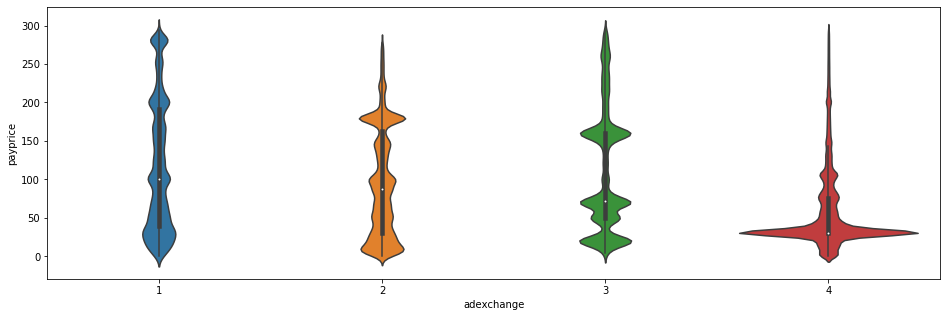

In [6]:
plt.subplots(figsize=(16,5))
ax = sns.violinplot(x="adexchange", y="payprice", data=df_2821)
plt.show()

## Explore bidding on Ad Exchange 2 (Google Adx)

In [34]:
adx = df_2821['adexchange'] == 2
tc = df_2821['adexchange'] == 3
# sort by payprice
sorted_adx = df_2821[adx].sort_values(by=['payprice'])
# sorted_adx.head()
sorted_tc = df_2821[tc].sort_values(by=['payprice'])
sorted_tc.head()

,click,weekday,hour,bidid,timestamp,logtype,ipinyouid,useragent,IP,region,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
701837,0,2,21,f2246f11cb195882ea501c0a7ad9f7eb,20131022211002839,1,DAMLA2D7tEQ,android_safari,119.251.16.*,3,...,90,Na,Na,5,10717,294,5,NaN,2821,NaN
114641,0,1,23,af14389f99d3bef21fdb3a584282d3a4,20131021231708785,1,DALNH8CHtB4,mac_safari,220.113.240.*,216,...,90,Na,Na,5,10717,294,5,NaN,2821,NaN
110488,0,1,18,4443dce7a70f6446400fe9be7da964bb,20131021183801543,1,DAI8SoCLG2B,windows_ie,124.64.60.*,1,...,90,Na,Na,5,10717,294,5,NaN,2821,"10684,14273,13042,10110,10031,10052,10063,11092"
124078,0,1,20,52c6ee5c717bbd1c038c5e4dd1e675d7,20131021201602283,1,DALJe1EovOC,windows_ie,61.191.209.*,106,...,90,Na,Na,5,10717,294,5,NaN,2821,NaN
1189312,0,3,10,f06ebf75e2d0c0b14a0f43c2e82d91c5,20131023101901900,1,DAL9ZE8avWp,windows_chrome,123.151.28.*,2,...,90,Na,Na,5,10717,294,5,NaN,2821,"14273,10063"


### Count number of bids by payprice

In [8]:
counts = sorted_adx['payprice'].reset_index()
counts = counts.groupby(by="payprice").count()[['index']]
counts.rename(columns={'index':'count'}, inplace=True)
counts.head(10)

,count
payprice,
0,1
4,916
5,15396
6,2397
7,2709
8,3182
9,2779
10,3170
11,3164


### Calculate cumulaltive stats

In [9]:
counts['cumsum_count'] = counts['count'].cumsum()
counts['bracket_cost'] = counts['count'] * counts.index 
counts['cumsum_cost'] = counts['bracket_cost'].cumsum()
counts['cummean_cost'] = counts['cumsum_cost'] / counts['cumsum_count']
counts.head(10)

,count,cumsum_count,bracket_cost,cumsum_cost,cummean_cost
payprice,,,,,
0,1,1,0,0,0.000000
4,916,917,3664,3664,3.995638
5,15396,16313,76980,80644,4.943542
6,2397,18710,14382,95026,5.078888
7,2709,21419,18963,113989,5.321864
8,3182,24601,25456,139445,5.668266
9,2779,27380,25011,164456,6.006428
10,3170,30550,31700,196156,6.420818
11,3164,33714,34804,230960,6.850567


# Plots

## Cumulative Impressions as bid price increases
$KPI_i(x_i)$ 

where KPI = Impressions, i = 2(Google adx)

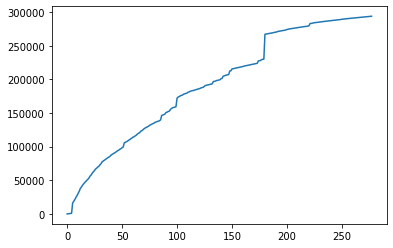

In [10]:
plt.plot(counts['cumsum_count'])
plt.show()

## Cumulative Cost as bid price increases
$KPI_i(x_i) * AP_i(x_i)$ 

where KPI = Impressions, i = 2(Google adx)

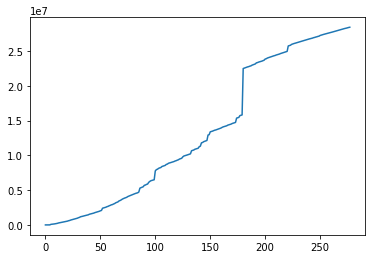

In [11]:
plt.plot(counts['cumsum_cost'])
plt.show()

## Cumulative Average pay price as bid price increases
$AP_i(x_i)$ 

where KPI = Impressions, i = 2(Google adx)

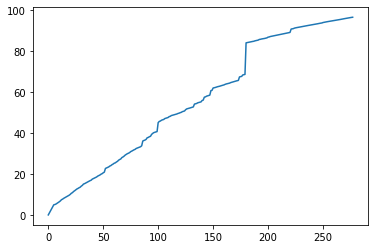

In [12]:
plt.plot(counts['cummean_cost'])
plt.show()

## Model the budget_i as decision variable directly

$\Sigma_i y_i \le Budget$

where $y_i$ is the total budget allocated for website i

In [13]:
sorted_adx = sorted_adx[1:]

y = sorted_adx[['payprice']].cumsum()
y["impressions"] = np.arange(len(y))

y.columns = ['y', 'impressions']

## Scatter Plot

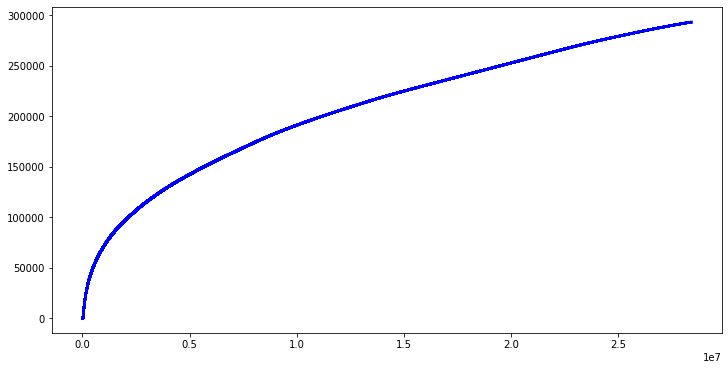

In [16]:
plt.subplots(figsize=(12,6))
plt.scatter(y['y'], y['impressions'], marker='.', c='b', alpha=0.002)
plt.show()

## Fit curve 1

/Users/zhongqihua/anaconda3/envs/bio/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zhongqihua/anaconda3/envs/bio/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


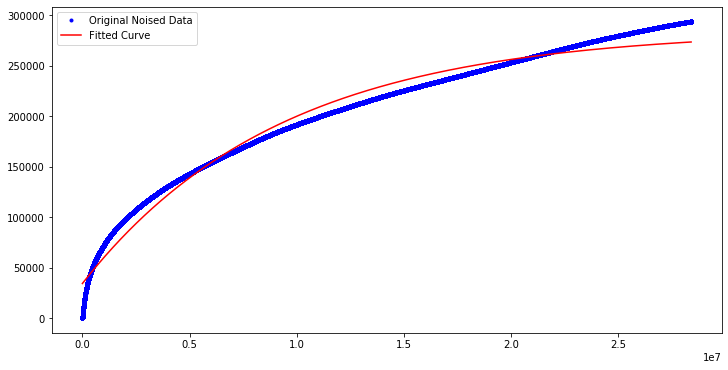

In [17]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


popt, pcov = curve_fit(func, y['y'], y['impressions'])

plt.subplots(figsize=(12,6))
plt.plot(y['y'], y['impressions'], 'b.', label="Original Noised Data")
plt.plot(y['y'], func(y['y'], *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

## Fit curve 2

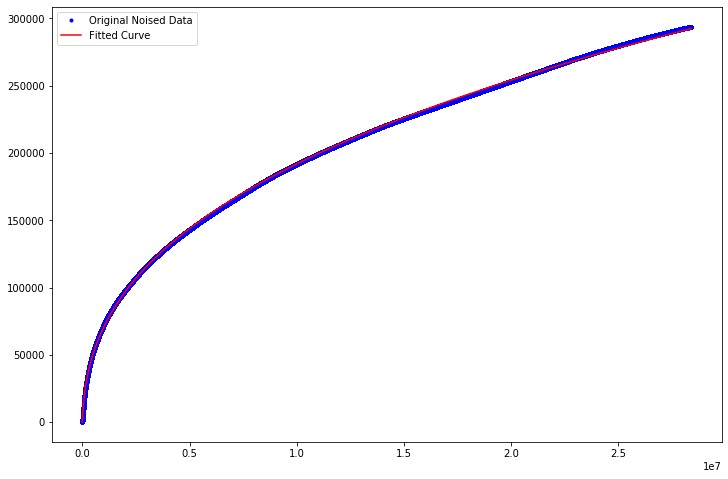

In [32]:
def func(x, a, b, c):
    return a * np.power( 1 + x/b, c) - a

# def func(x, a, b, c, d):
#     return a * np.power(x/b, c) + d

popt, pcov = curve_fit(func, y['y'], y['impressions'], p0=[400,10,0.4], maxfev=2000)

plt.subplots(figsize=(12,8))
plt.plot(y['y'], y['impressions'], 'b.', label="Original Noised Data")
plt.plot(y['y'], func(y['y'], *popt), 'r-', label="Fitted Curve")
plt.legend(loc="upper left")
plt.show()

In [33]:
print(popt)
print("MAE =",metrics.mean_absolute_error(y['impressions'], func(y['y'], *popt)))

[1.85251252e+04 1.52570015e+04 3.74584624e-01]
MAE = 994.3204049859967


**fitted curve:**

$18525 * (1 + x/15257)^{0.3746} - 18525$

In [29]:
 func(y['y'], *popt)

347868     -13786.401659
599584     -13562.028817
67879      -13400.429631
1318864    -13269.599389
1308916    -13157.736304
               ...      
102441     292772.937098
1066605    292774.082577
210223     292775.228049
1204498    292776.373514
721105     292777.518972
Name: y, Length: 293885, dtype: float64

In [35]:
counts = sorted_tc['payprice'].reset_index()
counts = counts.groupby(by="payprice").count()[['index']]
counts.rename(columns={'index':'count'}, inplace=True)
counts.head(10)

,count
payprice,
5,1400
10,4515
11,29
12,24
13,31
14,16
15,22
16,16
17,22


In [36]:
counts['cumsum_count'] = counts['count'].cumsum()
counts['bracket_cost'] = counts['count'] * counts.index 
counts['cumsum_cost'] = counts['bracket_cost'].cumsum()
counts['cummean_cost'] = counts['cumsum_cost'] / counts['cumsum_count']
counts.head(10)

,count,cumsum_count,bracket_cost,cumsum_cost,cummean_cost
payprice,,,,,
5,1400,1400,7000,7000,5.000000
10,4515,5915,45150,52150,8.816568
11,29,5944,319,52469,8.827221
12,24,5968,288,52757,8.839980
13,31,5999,403,53160,8.861477
14,16,6015,224,53384,8.875145
15,22,6037,330,53714,8.897466
16,16,6053,256,53970,8.916240
17,22,6075,374,54344,8.945514


In [37]:
sorted_tc

,click,weekday,hour,bidid,timestamp,logtype,ipinyouid,useragent,IP,region,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
701837,0,2,21,f2246f11cb195882ea501c0a7ad9f7eb,20131022211002839,1,DAMLA2D7tEQ,android_safari,119.251.16.*,3,...,90,Na,Na,5,10717,294,5,NaN,2821,NaN
114641,0,1,23,af14389f99d3bef21fdb3a584282d3a4,20131021231708785,1,DALNH8CHtB4,mac_safari,220.113.240.*,216,...,90,Na,Na,5,10717,294,5,NaN,2821,NaN
110488,0,1,18,4443dce7a70f6446400fe9be7da964bb,20131021183801543,1,DAI8SoCLG2B,windows_ie,124.64.60.*,1,...,90,Na,Na,5,10717,294,5,NaN,2821,"10684,14273,13042,10110,10031,10052,10063,11092"
124078,0,1,20,52c6ee5c717bbd1c038c5e4dd1e675d7,20131021201602283,1,DALJe1EovOC,windows_ie,61.191.209.*,106,...,90,Na,Na,5,10717,294,5,NaN,2821,NaN
1189312,0,3,10,f06ebf75e2d0c0b14a0f43c2e82d91c5,20131023101901900,1,DAL9ZE8avWp,windows_chrome,123.151.28.*,2,...,90,Na,Na,5,10717,294,5,NaN,2821,"14273,10063"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980620,0,2,12,15ae21d11cd7edffb8c8efed3d60ef21,20131022123202390,1,DADID61xxpr,windows_chrome,182.39.219.*,146,...,90,Na,Na,70,10734,294,294,NaN,2821,"10057,10059,10077,10075,10102,10006,10111,1011..."
85746,0,1,19,be10e2e71b683889f0e96b73ef5d44bb,20131021190102290,1,DA4Nv411cKc,windows_chrome,58.38.106.*,79,...,250,Na,Na,70,10722,294,294,NaN,2821,10006
610329,0,1,22,574178ae35649266ed9dc828c3a4839,20131021221001466,1,DALLG8AicpX,windows_chrome,36.7.145.*,106,...,250,Na,Na,70,10722,294,294,NaN,2821,NaN
752633,0,2,0,ce162200373202b71579ff1aadbb40e6,20131022001313471,1,D8GKglC~xee,windows_chrome,113.67.238.*,216,...,250,Na,Na,50,10722,294,294,NaN,2821,"10057,14273,10077,10083,10102,10006,10024,1011..."


In [38]:
# sorted_tc = sorted_adx[1:]

y = sorted_tc[['payprice']].cumsum()
y["impressions"] = np.arange(len(y))

y.columns = ['y', 'impressions']

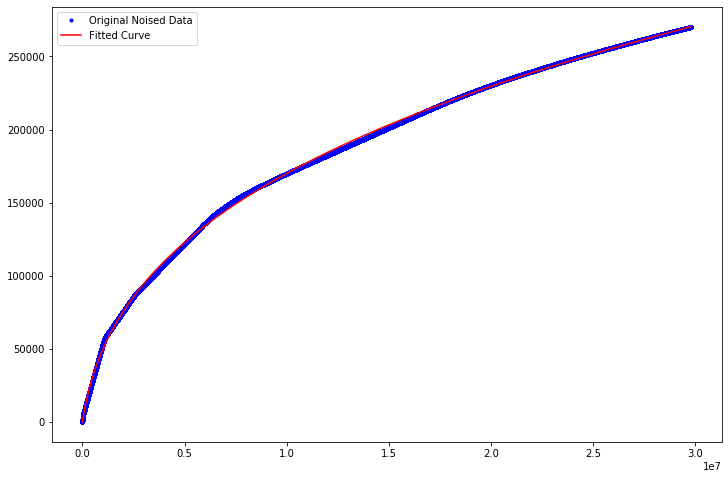

In [39]:
def func(x, a, b, c):
    return a * np.power( 1 + x/b, c) - a


popt, pcov = curve_fit(func, y['y'], y['impressions'], p0=[400,10,0.4], maxfev=2000)

plt.subplots(figsize=(12,8))
plt.plot(y['y'], y['impressions'], 'b.', label="Original Noised Data")
plt.plot(y['y'], func(y['y'], *popt), 'r-', label="Fitted Curve")
plt.legend(loc="upper left")
plt.show()

In [40]:
print(popt)
print("MAE =",metrics.mean_absolute_error(y['impressions'], func(y['y'], *popt)))

[8.06186368e+04 2.75380867e+05 3.13406009e-01]
MAE = 1439.2475936266112
